# Redes neuronales

En este notebook clasificaremos si una instancia tiene alto poder adquisitivo mediante redes neuronales.

Se utilizarán dos preprocessings diferentes:

* PCA con el 90% de la varianza explicada

* Preprocessing primera parte

* Preprocessing mejores features de un árbol

In [1]:
# Red neuronal
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Model

# Otros
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import utils
from preprocessing import preprocessing_significantes
from preprocessing import standard_preprocessing_base_parte_1
from preprocessing import standard_preprocessing_mejores_por_arbol

# Metricas
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

In [2]:
df = utils.get_data()

## Modelo 1 - Significantes 90% varianza

Entrenaremos una red neuronal relativamente grande, pero bien regularizada:

* 66 Nodos de entrada. (con regularización l1 y l2)

* 50 Nodos en capa oculta (con dropout de 50% y regularización l2) [Relu]

* 20 Nodos en capa oculta (con dropout de 20% y regularización l2) [Relu]

* 1 Nodo de output [Sigmoid]

Esto es debido a que en la entrada hay "muchas features".

In [4]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=27, stratify = Y)

X_train_1, X_test_1 = preprocessing_significantes(X_train_1, X_test_1, variance=0.90)

/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['ganancia_perdida_declarada_bolsa_argentina'].apply(

#### Creando la red neuronal

In [35]:
n_in = X_train_1.shape[1]

m1 = Sequential([
  Dense(n_in,
        input_dim=n_in,
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0002, l2=0.0005)),
  Dense(50,
        activation='relu',
        kernel_regularizer='l2'),
  Dropout(0.30),
  Dense(20,
        activation='relu',
        kernel_regularizer='l2'),
  Dropout(0.30),
  Dense(1, activation='sigmoid')
])

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
m1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [37]:
m1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 65)                4290      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                3300      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                1020      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
Total params: 8,631
Trainable params: 8,631
Non-trainable params: 0
____________________________________________________

Vemos que tinee 8.631 parámetros a estimar. Pondremos `batch_size` de 20 para acelerar el proceso.

#### Entrenando

In [38]:
h1 = m1.fit(X_train_1, y_train_1, epochs=100, batch_size=20, verbose=1, validation_split=0)

Epoch 1/100
1221/1221 [==============================] - 2s 1ms/step - loss: 1.6971 - accuracy: 0.5873 - auc_3: 0.5806
Epoch 2/100
1221/1221 [==============================] - 1s 987us/step - loss: 1.3368 - accuracy: 0.7842 - auc_3: 0.7853
Epoch 3/100
1221/1221 [==============================] - 1s 1ms/step - loss: 1.1871 - accuracy: 0.8007 - auc_3: 0.8300
Epoch 4/100
1221/1221 [==============================] - 1s 1ms/step - loss: 1.0648 - accuracy: 0.8105 - auc_3: 0.8473
Epoch 5/100
1221/1221 [==============================] - 1s 1ms/step - loss: 0.9618 - accuracy: 0.8195 - auc_3: 0.8597
Epoch 6/100
1221/1221 [==============================] - 1s 1ms/step - loss: 0.8815 - accuracy: 0.8212 - auc_3: 0.8595
Epoch 7/100
1221/1221 [==============================] - 1s 1ms/step - loss: 0.8027 - accuracy: 0.8254 - auc_3: 0.8696
Epoch 8/100
1221/1221 [==============================] - 1s 1ms/step - loss: 0.7404 - accuracy: 0.8309 - auc_3: 0.8717
Epoch 9/100
1221/1221 [=======================

### Métricas

Veamos cómo se comportó la pérdida (`binary_crossentropy`) a lo largo de las épocas, queremos ver si el modelo puede entrenar más o si "se estancó", además también percibir si hubo overfitting o underfitting evaluando las curvas de loss y la de validation_loss.

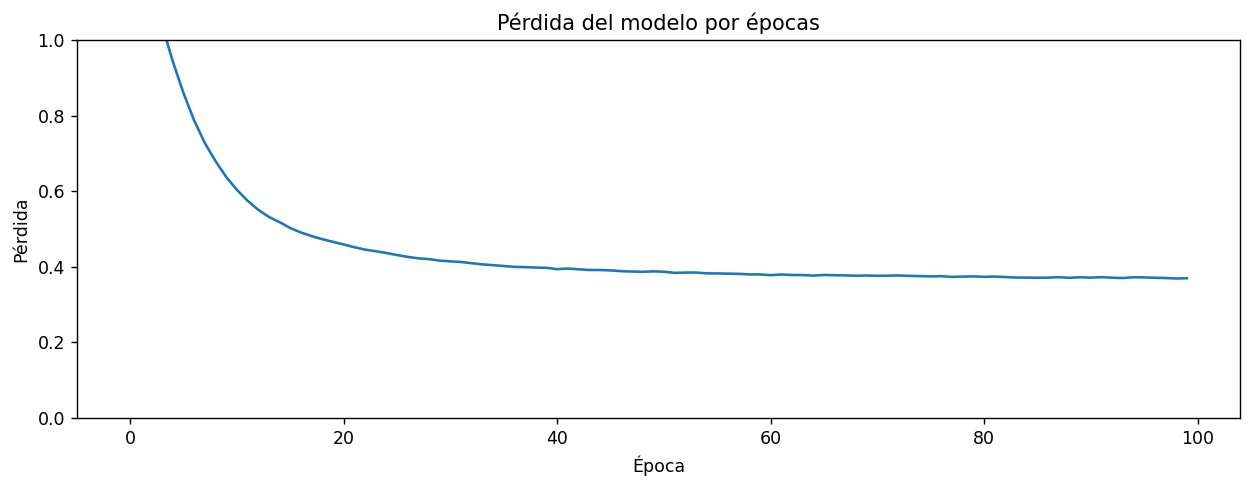

In [39]:
plt.figure(dpi=125, figsize=(12, 4))
plt.plot(h1.history['loss'], label="loss")
plt.title('Pérdida del modelo por épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.ylim(0, 1)
plt.show()

Vemos que la curva decrece rápidamente en las primeras épocas pero luego de la 60 se mantuvo constante. Por lo que deducimos que seguramente el modelo terminó de entrenar.

Veamos entonces las métricas que nos interesan, que en este caso son las de RocAUC y accuracy.

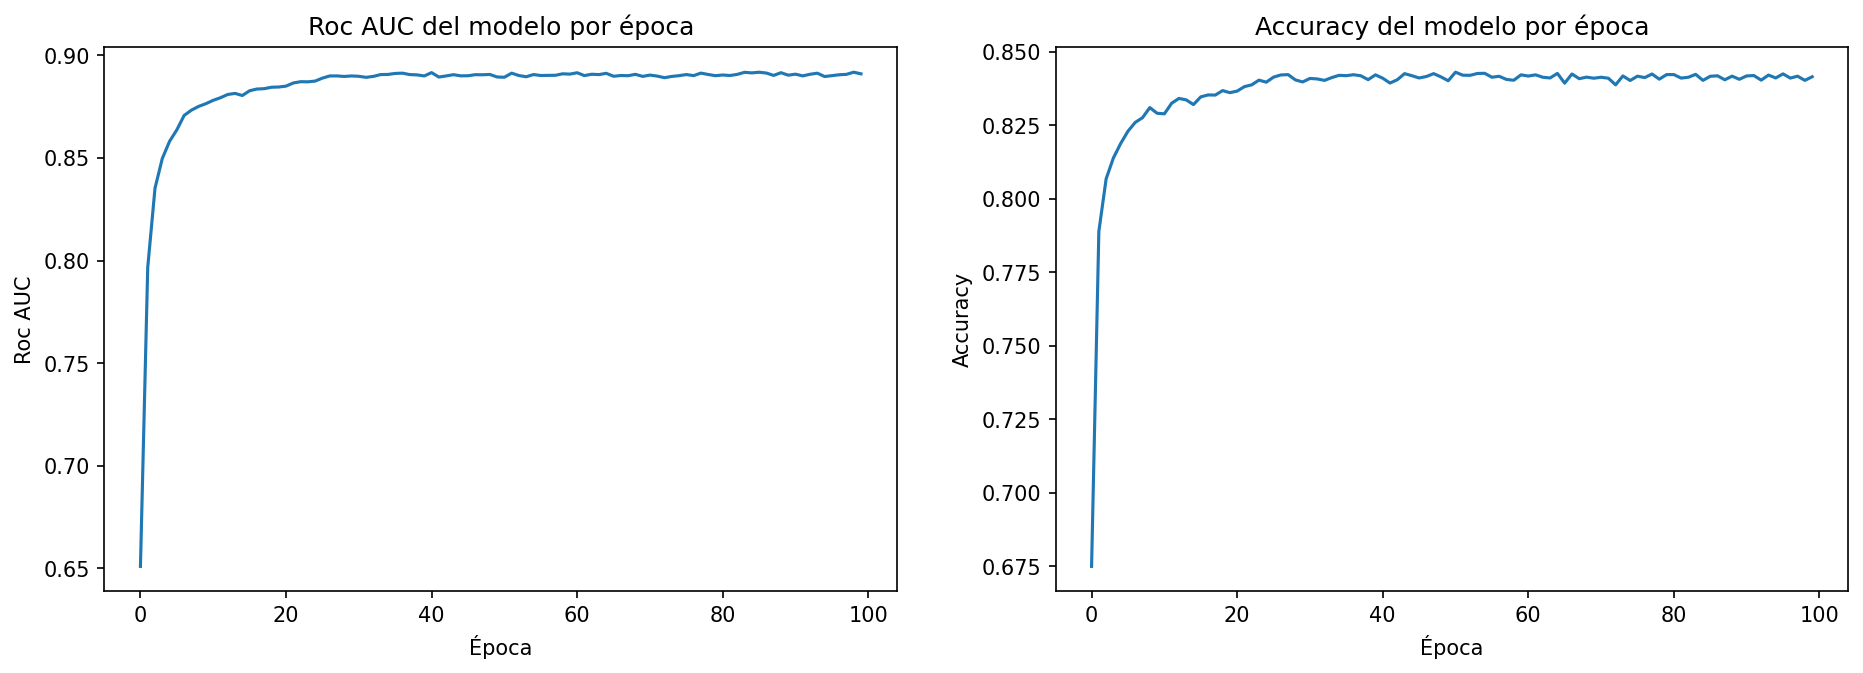

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

ax1.plot(h1.history['auc'], label="Roc AUC")
ax1.set_title('Roc AUC del modelo por época')
ax1.set_ylabel('Roc AUC')
ax1.set_xlabel('Época')

ax2.plot(h1.history['accuracy'], label="Accuracy")
ax2.set_title('Accuracy del modelo por época')

ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Época')


plt.show()

Podemos ver que la red neuronal aprendió mucho en un principio (tanto para RocAUC como para Accuracy) pero luego dicho crecimiento quedó prácticamente constante.

Además el Accuracy es decente, pero hay que tener en cuenta que dicho valor es sobre train. Veamos qué valores se obtuvieron en test.

In [41]:
print(classification_report(y_test_1, m1.predict(X_test_1, verbose=4) > 0.50, digits=4))

              precision    recall  f1-score   support

           0     0.8812    0.9207    0.9005      6181
           1     0.7089    0.6087    0.6550      1960

    accuracy                         0.8456      8141
   macro avg     0.7950    0.7647    0.7778      8141
weighted avg     0.8397    0.8456    0.8414      8141



Vemos que se trata de un modelo regular en general, un buen accuracy cercano al 84.6%

Mucho recall en ceros y buena precision para estos.

Como es usual, poco recall para unos, pero también poca precision para ellos.

Veamos la curva Roc y su puntuación AUC

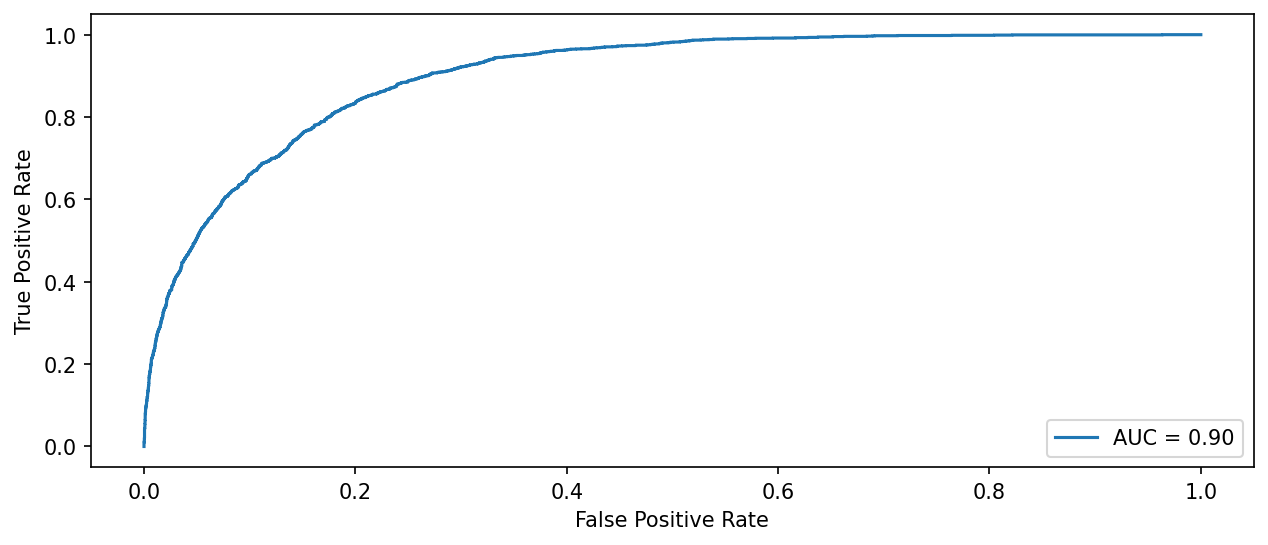

In [42]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)

fpr, tpr, thresholds = roc_curve(y_test_1, m1.predict(X_test_1))
auc = roc_auc_score(y_test_1, m1.predict(X_test_1))

r = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
r.plot(ax=ax)

plt.show()

In [43]:
auc

0.900485317084284

Vemos que se trata de un modelo bastante bueno. Aproximadamente 90.0 de RocAUC score.

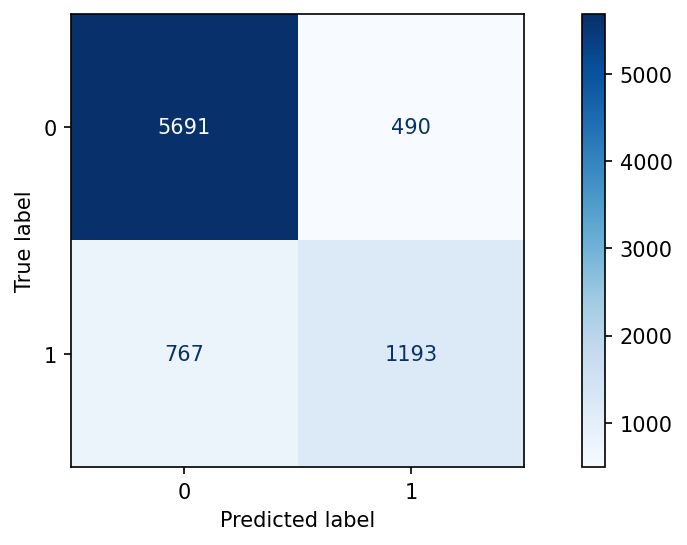

In [44]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
c = ConfusionMatrixDisplay(confusion_matrix(y_test_1, m1.predict(X_test_1)>0.5))
c.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Modelo 2 - Preprocessing parte 1

Ahora entrenaremos una red neuronal mucho más pequeña, poco regularizada

* 7 Nodos de entrada. (con regularización l2)

* 14 Nodos en capa oculta. (con dropout de 25% y regularización l2) [Relu]

* 4 Nodos en capa oculta. [Relu]

* 1 Nodo de output [Sigmoid]

Decidimos realizar una red neuronal más pequeña ya que la cantidad de entradas es menor.

In [62]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=27, stratify = Y)

X_train_2, X_test_2 = standard_preprocessing_base_parte_1(X_train_2, X_test_2)

#### Creando la red neuronal

In [63]:
n_in = X_train_2.shape[1]

m2 = Sequential()
m2.add(Dense(n_in,
            input_dim=n_in,
            kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
m2.add(Dropout(0.25))
m2.add(Dense(14,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(0.0001)))
m2.add(Dropout(0.25))
m2.add(Dense(4,
            activation='relu'))
m2.add(Dropout(0.25))
m2.add(Dense(1, activation='sigmoid'))

In [64]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00002)
m2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [65]:
m2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 7)                 56        
_________________________________________________________________
dropout_19 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 14)                112       
_________________________________________________________________
dropout_20 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 60        
_________________________________________________________________
dropout_21 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                

Vemos que la cantidad de parámetros a estimar es muy pequeña en comparación con antes. Por lo que trataremos de ir por más épocas y menor learning rate.

Entrenando

In [66]:
h2 = m2.fit(X_train_2, y_train_2, epochs=250, batch_size=10, verbose=1, validation_split=0.0)

Epoch 1/250
2442/2442 [==============================] - 4s 1ms/step - loss: 0.6130 - accuracy: 0.6789 - auc_8: 0.5920
Epoch 2/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.5855 - accuracy: 0.7115 - auc_8: 0.6061
Epoch 3/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.5595 - accuracy: 0.7292 - auc_8: 0.6369
Epoch 4/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.5502 - accuracy: 0.7392 - auc_8: 0.6409
Epoch 5/250
2442/2442 [==============================] - 4s 2ms/step - loss: 0.5372 - accuracy: 0.7469 - auc_8: 0.6586
Epoch 6/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.5250 - accuracy: 0.7502 - auc_8: 0.6804
Epoch 7/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.5178 - accuracy: 0.7504 - auc_8: 0.6933
Epoch 8/250
2442/2442 [==============================] - 5s 2ms/step - loss: 0.5167 - accuracy: 0.7504 - auc_8: 0.7068
Epoch 9/250
2442/2442 [=========================

2442/2442 [==============================] - 3s 1ms/step - loss: 0.3859 - accuracy: 0.8213 - auc_8: 0.8570
Epoch 138/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.3863 - accuracy: 0.8179 - auc_8: 0.8588
Epoch 139/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.3861 - accuracy: 0.8182 - auc_8: 0.8602
Epoch 140/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.4028 - accuracy: 0.8114 - auc_8: 0.8462
Epoch 141/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.3978 - accuracy: 0.8156 - auc_8: 0.8490
Epoch 142/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.3939 - accuracy: 0.8115 - auc_8: 0.8553
Epoch 143/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.3979 - accuracy: 0.8112 - auc_8: 0.8533
Epoch 144/250
2442/2442 [==============================] - 3s 1ms/step - loss: 0.3936 - accuracy: 0.8173 - auc_8: 0.8501
Epoch 145/250
2442/2442 [=====================

### Métricas

Veamos cómo se comportó la pérdida (`binary_crossentropy`) a lo largo de las épocas, queremos ver si el modelo puede entrenar más o si "se estancó", además también percibir si hubo overfitting o underfitting evaluando las curvas de loss y la de validation_loss.

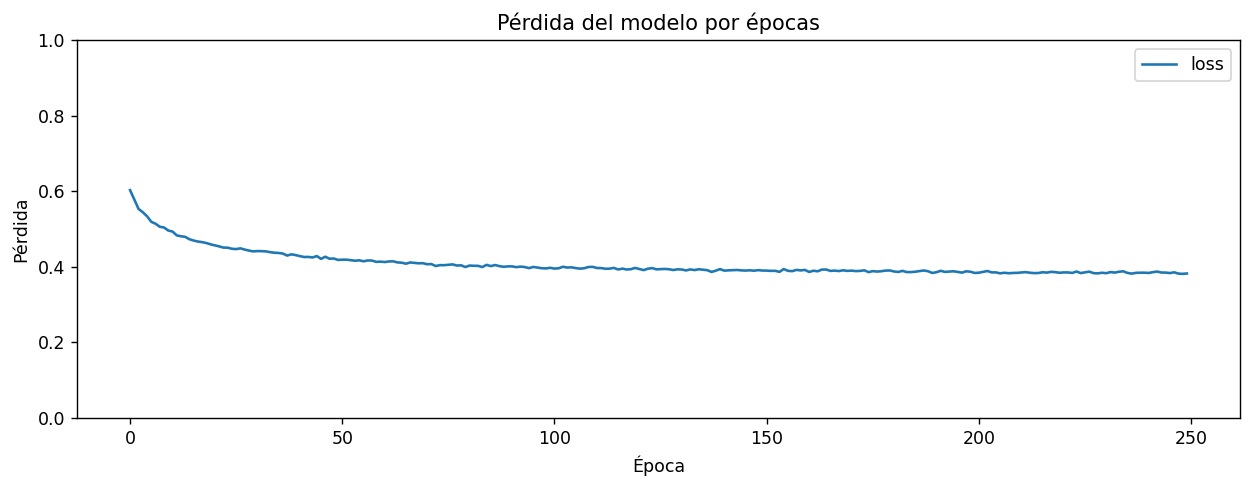

In [68]:
plt.figure(dpi=125, figsize=(12, 4))
plt.plot(h2.history['loss'], label="loss")
plt.title('Pérdida del modelo por épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.ylim(0, 1)
plt.legend()
plt.show()

Vemos nuevamente que las curvas están pegadas. Por lo que a priori la red hizo un buen trabajo con respecto al sobreajuste y el desajuste.

A diferencia del modelo anterior, este modelo alcanza la estabilidad muy temprano, ya por la época 20 se mantiene constante la pérdida. Por lo que se ve que no son necesarias tantas épocas para obtener un buen modelo.

Veamos entonces las métricas que nos interesan, que en este caso son las de RocAUC y accuracy.

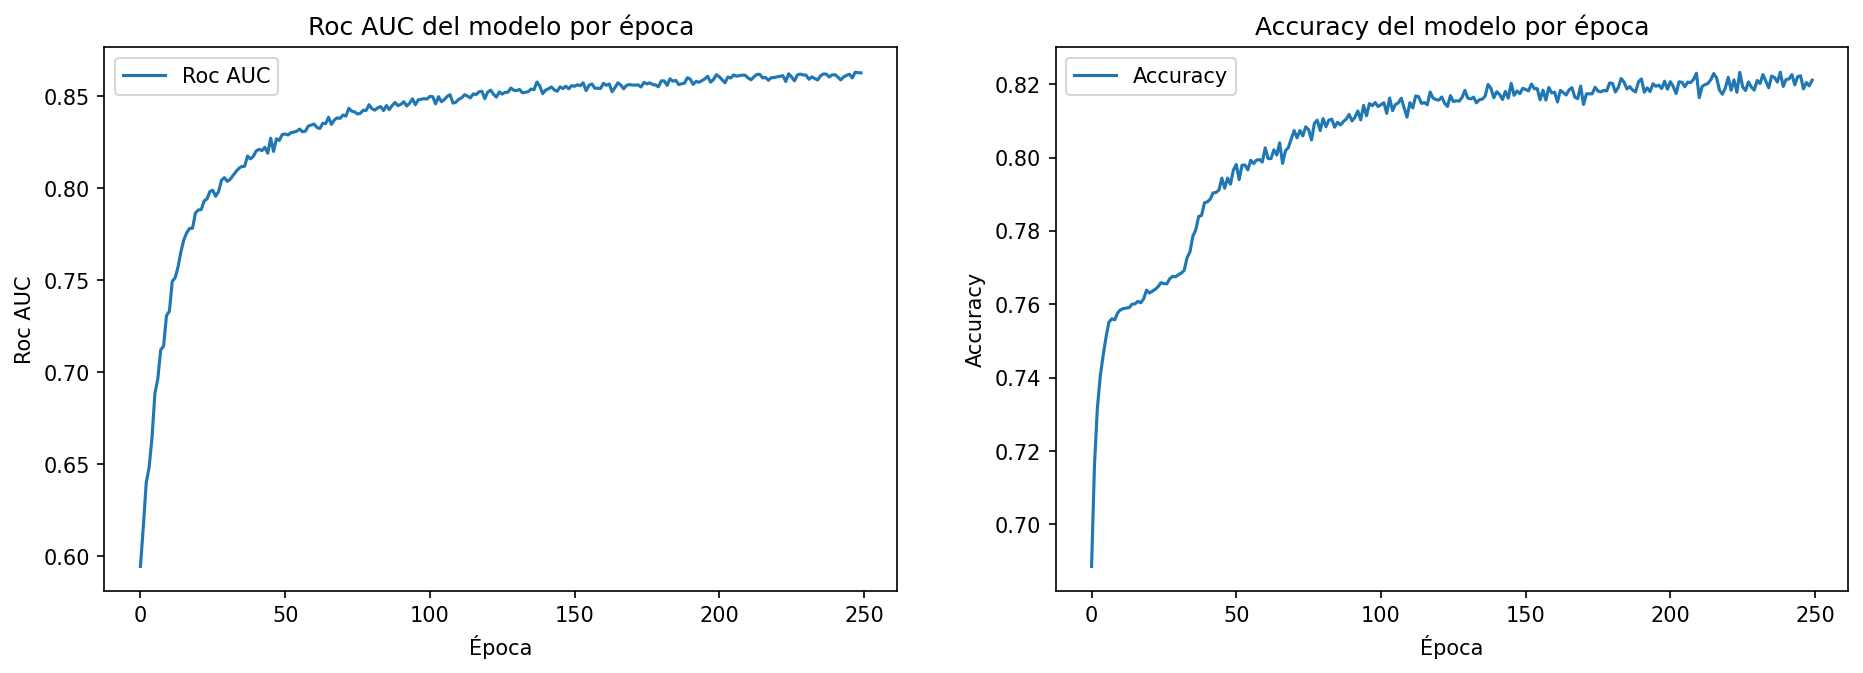

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

ax1.plot(h2.history['auc_1'], label="Roc AUC")
ax1.set_title('Roc AUC del modelo por época')
ax1.set_ylabel('Roc AUC')
ax1.set_xlabel('Época')
ax1.legend()

ax2.plot(h2.history['accuracy'], label="Accuracy")
ax2.set_title('Accuracy del modelo por época')

ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Época')
ax2.legend()


plt.show()

Las conclusiones de las figuras son similares a las del primer modelo.

Vemos que el RocAUC se mantiene constantemente por encima en validation y no en train, a diferencia del Accuracy que en general está por encima en train.

Veamos todas las métricas

In [70]:
print(classification_report(y_test_2, m2.predict(X_test_2) > 0.50, digits=4))

              precision    recall  f1-score   support

           0     0.8546    0.9434    0.8968      6181
           1     0.7344    0.4939    0.5906      1960

    accuracy                         0.8352      8141
   macro avg     0.7945    0.7186    0.7437      8141
weighted avg     0.8257    0.8352    0.8231      8141



Un modelo regular, se obtuvo un Accuracy de 83.5%.

Las observaciones son similares a la del modelo anterior.

Veamos la curva Roc y su puntuación AUC

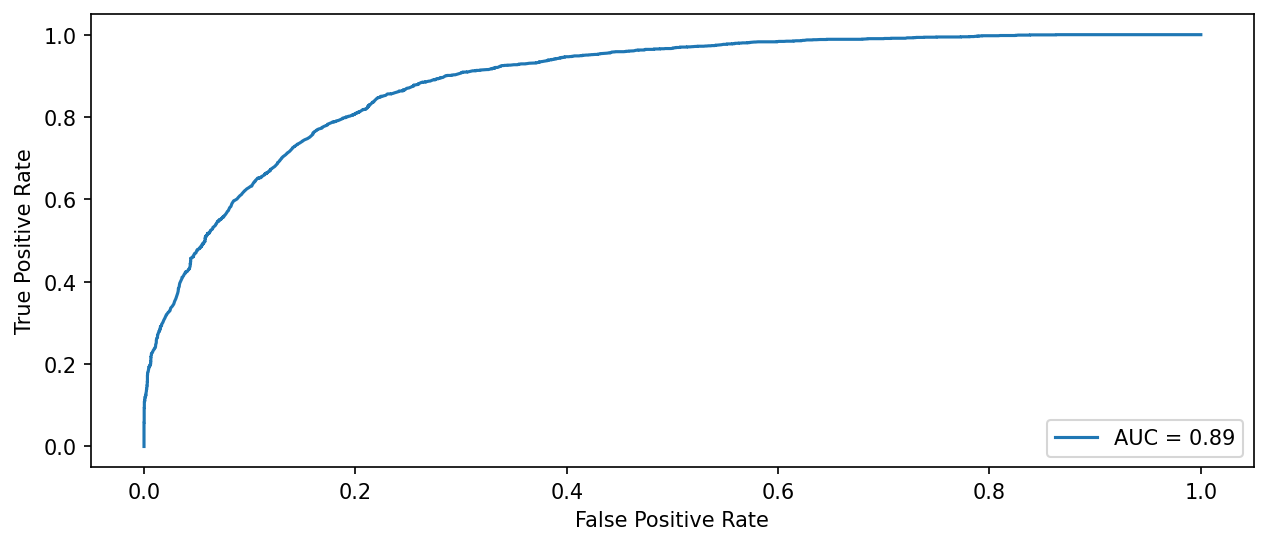

In [71]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)

fpr, tpr, thresholds = roc_curve(y_test_2, m2.predict(X_test_2))
auc = roc_auc_score(y_test_2, m2.predict(X_test_2))

r = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
r.plot(ax=ax)

plt.show()

In [72]:
auc

0.8885523526673249

Un RocAUC regular, de 88.9%. Obviamente no superando al primer modelo.

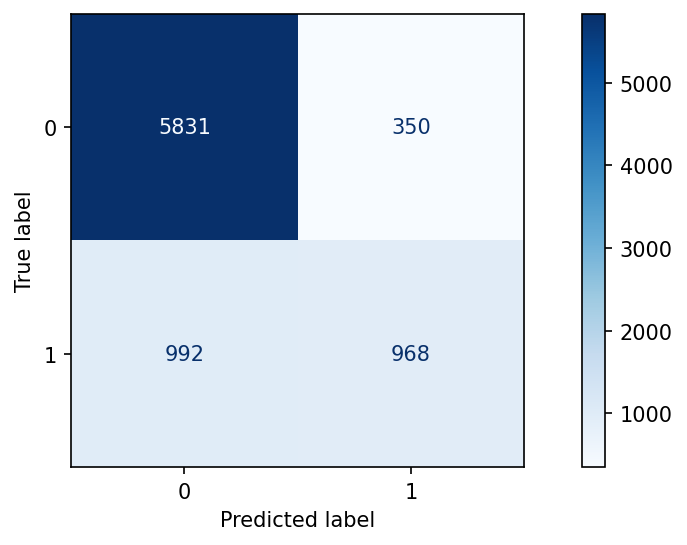

In [73]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
c = ConfusionMatrixDisplay(confusion_matrix(y_test_2, m2.predict(X_test_2)>0.5))
c.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

Vemos incluso que la matriz de confusión dio mal.

## Modelo 3 - Preprocessing standard mejores por árbol

Ahora entrenaremos una red neuronal mucho más pequeña, sin regularización.

* 8 Nodos de entrada.

* 4 Nodos en la primera capa oculta [Relu]

* 4 Nodos en la segunda capa oculta [Relu]

* 1 Nodo de output [Sigmoid]

In [74]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y, random_state=27, stratify = Y)

X_train_3, X_test_3 = standard_preprocessing_mejores_por_arbol(X_train_3, X_test_3)

#### Creando la red neuronal

In [79]:
n_in = X_train_3.shape[1]

m3 = Sequential()
m3.add(Dense(8, input_dim=n_in))
m3.add(Dense(4, activation='relu'))
m3.add(Dense(4, activation='relu'))
m3.add(Dense(1, activation='sigmoid'))

In [80]:
m3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_42 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


Vemos que la cantidad de parámetros a estimar es muy pequeña en comparación con antes.

Entrenando

In [81]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
m3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

h3 = m3.fit(X_train_3, y_train_3, epochs=150, batch_size=20, verbose=1, validation_split=0)

Epoch 1/150
1221/1221 [==============================] - 2s 983us/step - loss: 0.8215 - accuracy: 0.4871 - auc_11: 0.7192
Epoch 2/150
1221/1221 [==============================] - 1s 993us/step - loss: 0.7750 - accuracy: 0.5438 - auc_11: 0.7245
Epoch 3/150
1221/1221 [==============================] - 3s 2ms/step - loss: 0.7368 - accuracy: 0.5990 - auc_11: 0.7292
Epoch 4/150
1221/1221 [==============================] - 3s 3ms/step - loss: 0.7103 - accuracy: 0.6533 - auc_11: 0.7417
Epoch 5/150
1221/1221 [==============================] - 2s 2ms/step - loss: 0.6848 - accuracy: 0.6947 - auc_11: 0.7625
Epoch 6/150
1221/1221 [==============================] - 2s 2ms/step - loss: 0.6576 - accuracy: 0.7185 - auc_11: 0.7815
Epoch 7/150
1221/1221 [==============================] - 4s 3ms/step - loss: 0.6436 - accuracy: 0.7322 - auc_11: 0.7862
Epoch 8/150
1221/1221 [==============================] - 4s 3ms/step - loss: 0.6239 - accuracy: 0.7555 - auc_11: 0.8006
Epoch 9/150
1221/1221 [=============

1221/1221 [==============================] - 1s 1ms/step - loss: 0.3590 - accuracy: 0.8375 - auc_11: 0.8809
Epoch 69/150
1221/1221 [==============================] - 1s 936us/step - loss: 0.3551 - accuracy: 0.8396 - auc_11: 0.8839
Epoch 70/150
1221/1221 [==============================] - 1s 838us/step - loss: 0.3583 - accuracy: 0.8387 - auc_11: 0.8820
Epoch 71/150
1221/1221 [==============================] - 1s 903us/step - loss: 0.3620 - accuracy: 0.8352 - auc_11: 0.8792
Epoch 72/150
1221/1221 [==============================] - 1s 821us/step - loss: 0.3528 - accuracy: 0.8423 - auc_11: 0.8845
Epoch 73/150
1221/1221 [==============================] - 1s 798us/step - loss: 0.3500 - accuracy: 0.8435 - auc_11: 0.8841
Epoch 74/150
1221/1221 [==============================] - 1s 732us/step - loss: 0.3585 - accuracy: 0.8368 - auc_11: 0.8806
Epoch 75/150
1221/1221 [==============================] - 2s 1ms/step - loss: 0.3540 - accuracy: 0.8395 - auc_11: 0.8807
Epoch 76/150
1221/1221 [=========

1221/1221 [==============================] - 1s 742us/step - loss: 0.3461 - accuracy: 0.8336 - auc_11: 0.8879
Epoch 136/150
1221/1221 [==============================] - 1s 747us/step - loss: 0.3447 - accuracy: 0.8376 - auc_11: 0.8919
Epoch 137/150
1221/1221 [==============================] - 1s 785us/step - loss: 0.3353 - accuracy: 0.8420 - auc_11: 0.8939
Epoch 138/150
1221/1221 [==============================] - 3s 2ms/step - loss: 0.3454 - accuracy: 0.8367 - auc_11: 0.8882
Epoch 139/150
1221/1221 [==============================] - 3s 2ms/step - loss: 0.3383 - accuracy: 0.8422 - auc_11: 0.8924
Epoch 140/150
1221/1221 [==============================] - 3s 2ms/step - loss: 0.3351 - accuracy: 0.8464 - auc_11: 0.8946
Epoch 141/150
1221/1221 [==============================] - 1s 1ms/step - loss: 0.3412 - accuracy: 0.8379 - auc_11: 0.8917
Epoch 142/150
1221/1221 [==============================] - 2s 2ms/step - loss: 0.3372 - accuracy: 0.8394 - auc_11: 0.8917
Epoch 143/150
1221/1221 [=======

### Métricas

Veamos cómo se comportó la pérdida (`binary_crossentropy`) a lo largo de las épocas, queremos ver si el modelo puede entrenar más o si "se estancó", además también percibir si hubo overfitting o underfitting evaluando las curvas de loss y la de validation_loss.

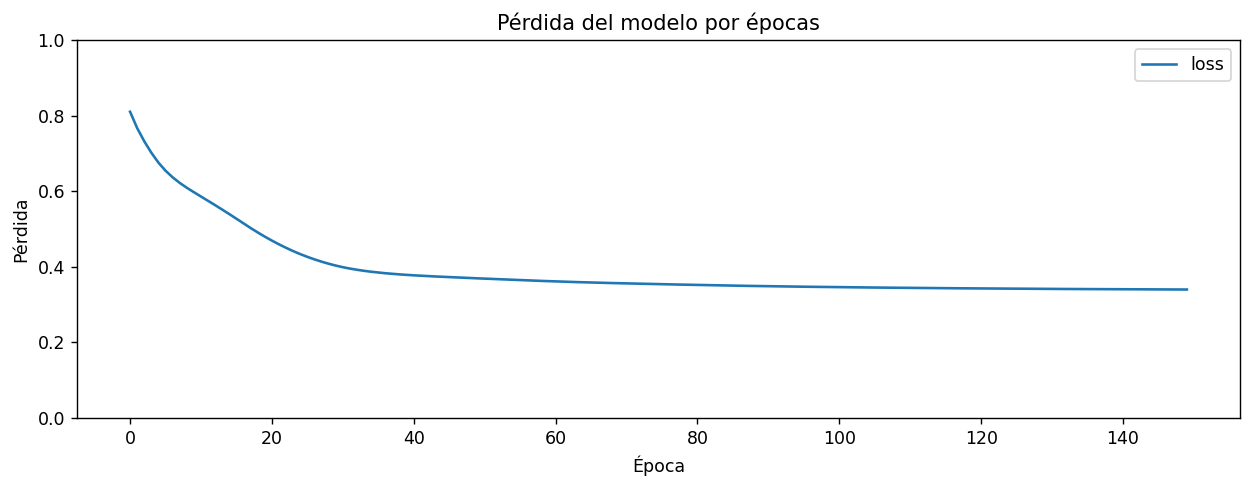

In [83]:
plt.figure(dpi=125, figsize=(12, 4))
plt.plot(h3.history['loss'], label="loss")
plt.title('Pérdida del modelo por épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.ylim(0, 1)
plt.legend()
plt.show()

Vemos que las curvas están pegadas, eso nos da idea de que el modelo no sobreajuste ni tampoco desajusto.


Veamos las demás métricas.

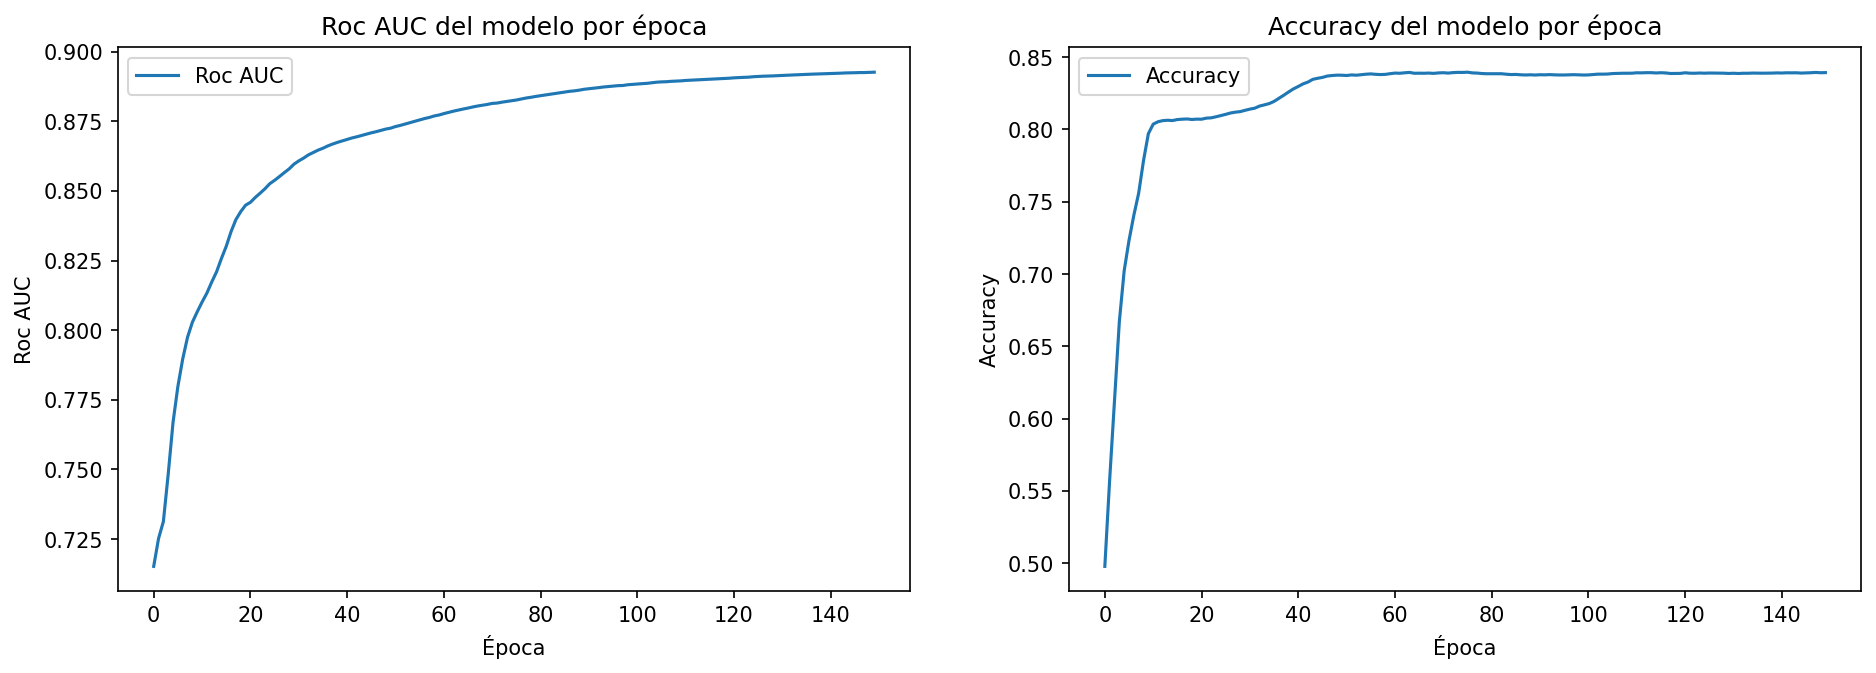

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

ax1.plot(h3.history['auc_2'], label="Roc AUC")
ax1.set_title('Roc AUC del modelo por época')
ax1.set_ylabel('Roc AUC')
ax1.set_xlabel('Época')
ax1.legend()

ax2.plot(h3.history['accuracy'], label="Accuracy")
ax2.set_title('Accuracy del modelo por época')

ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Época')
ax2.legend()


plt.show()

Luego, vemos que apartir de la época 120 el RocAUC no parece crecer, y desde la época 60 que el accuracy no parece crecer.

Veamos las métricas de predicción sobre el test.

In [85]:
print(classification_report(y_test_3, m3.predict(X_test_3) > 0.50, digits=4))

              precision    recall  f1-score   support

           0     0.8764    0.9188    0.8971      6181
           1     0.6978    0.5913    0.6402      1960

    accuracy                         0.8399      8141
   macro avg     0.7871    0.7551    0.7686      8141
weighted avg     0.8334    0.8399    0.8352      8141



Se trata entonces de un modelo decente, nada que ya no se haya visto. 84.0% de accuracy. Poca recall para unos como es usual.

Veamos entonces la curva ROC y su puntuación AUC

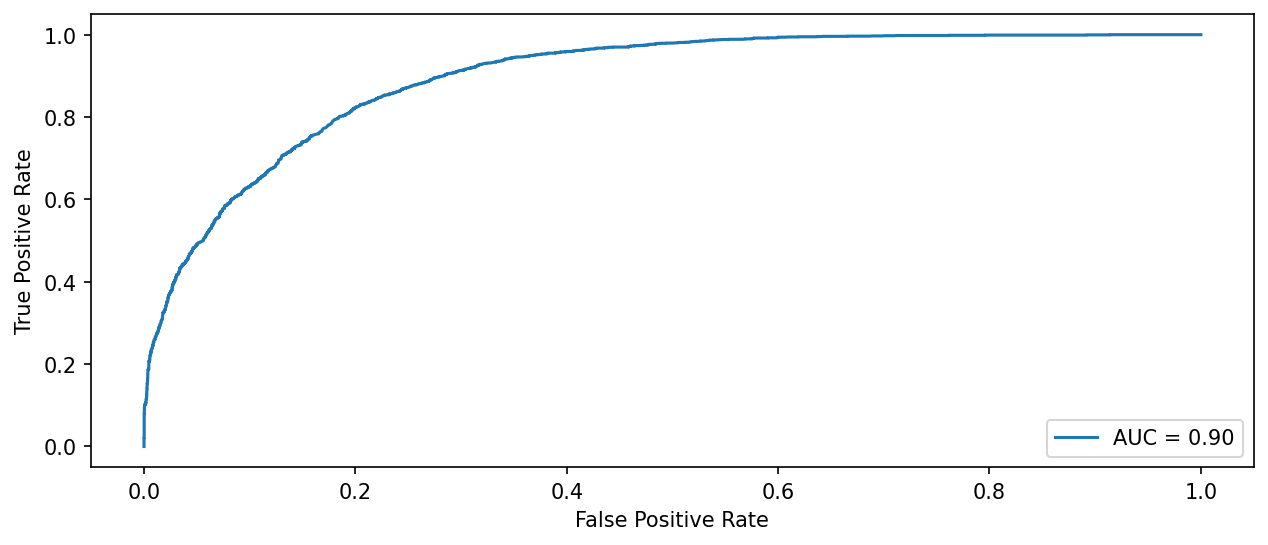

In [86]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)

fpr, tpr, thresholds = roc_curve(y_test_3, m3.predict(X_test_3))
auc = roc_auc_score(y_test_3, m3.predict(X_test_3))

r = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
r.plot(ax=ax)

plt.show()

In [87]:
auc

0.8955015617313096

Un RocAUC de 89.6% es decente.

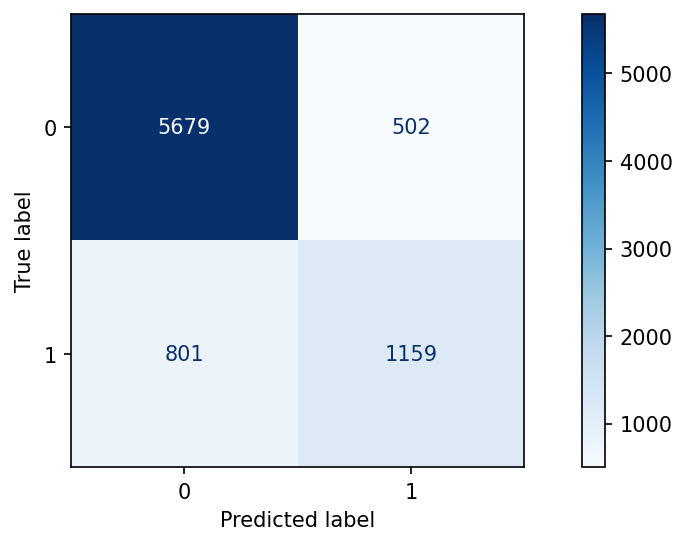

In [88]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
c = ConfusionMatrixDisplay(confusion_matrix(y_test_3, m3.predict(X_test_3)>0.5))
c.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Persistencia de los modelos.

In [118]:
tf.keras.models.save_model(m1, "Modelos/RedesNeuronales/m1")
tf.keras.models.save_model(m2, "Modelos/RedesNeuronales/m2")
tf.keras.models.save_model(m3, "Modelos/RedesNeuronales/m3")

INFO:tensorflow:Assets written to: Modelos/RedesNeuronales/m1/assets
INFO:tensorflow:Assets written to: Modelos/RedesNeuronales/m2/assets
INFO:tensorflow:Assets written to: Modelos/RedesNeuronales/m3/assets


# Predicción de HoldOut

Usaremos para predecir la Red Neuronal obtenida para el preprocessing standardBase.

In [119]:
m1 = loaded_model = tf.keras.models.load_model('Modelos/RedesNeuronales/m1')

In [144]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    Xv = pd.get_dummies(Xv)
    Xv, _, _, _ = train_test_split(Xv, dfv['tiene_alto_valor_adquisitivo'], random_state=27, stratify = dfv['tiene_alto_valor_adquisitivo'])

    ids, X = utils.get_holdout_data()
    X = pd.get_dummies(X)

    notInHoldout=[]
    for c in Xv.columns:
        if c not in X.columns:
            notInHoldout.append(c)
    X[notInHoldout] = 0

    Xv, X = preprocessing_significantes(Xv, X, variance=0.9)
    return ids, X

In [145]:
ids, X = holdout()

In [150]:
utils.escribir_holdout((m1.predict(X)>0.5).flatten().astype(int), "10 - RedesNeuronales", ids)